Our multiverse project showed an unsatisfactory result, and we are not sure what caused this result.Our guesses are as follows:
- the data itself has no effect
- the model cannot explain the effect
- HDDM tool cannot capture true effect

First, we need to first confirm that the tool we are using is effective and that its robustness is guaranteed.

So, this script is intended to test the parameter recovery for Wiecki(2013)."HDDM: Hierarchical Bayesian estimation of the Drift-Diffusion Model in Python".Front Neuroinform

The code is from
https://github.com/hddm-devs/HDDM-paper

The script is intended to compare different fitting methods('HDDMRegressor', 'SingleRegressor', 'HDDM2', 'HDDM2Single', 'MLRegressor'), models('EstimationHDDMRegressor', 'EstimationHDDM2', 'EstimationHDDM2Single', 'SingleRegressor', 'SingleRegOptimization'), trials or subjects, which has an impact on the true effect.

Since our goal is only to test the effect of the HDDMRegressor, we only select the snippets of interest.

The code is mainly from https://github.com/hddm-devs/HDDM-paper/estimation.py line 420-571

The stucture of the script is as follows:
- Load the required package
- Set the hyperparameter(of ddm) of the test
- Generate random parameter(of ddm, omitted below) and performance
- Constructing the model and fitting it
- Inspect the results

# Load the required package

In [1]:
#system
import sys
import os
#variable
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import pandas as pd
#plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import ptitprince as pt
# model
import kabuki
import hddm
from hddm import HDDMRegressor
# stats
import bambi as bmb
from scipy.stats import pearsonr

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
print(f'The version of python is {sys.version}')
print(f'The version of numpy is {np.__version__}')
print(f'The version of pandas is {pd.__version__}')
print(f'The version of matplotlib is {matplotlib.__version__}')
print(f'The version of seaborn is {sns.__version__}')
print(f'The version of arviz is {az.__version__}')
print(f'The version of hddm is {hddm.__version__}')
print(f'The version of kabuki is {kabuki.__version__}')
print(f'The version of bambi is {bmb.__version__}')

The version of python is 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
The version of numpy is 1.20.3
The version of pandas is 1.3.5
The version of matplotlib is 3.3.4
The version of seaborn is 0.11.2
The version of arviz is 0.12.0
The version of hddm is 0.8.0
The version of kabuki is 0.6.4
The version of bambi is 0.8.0


In [3]:
# set the figure theme
sns.set_theme(style="whitegrid")
# set random seed
np.random.seed(123)

# Set the hyperparameter of the test

we set the numbers of the params, subjects and the effect of the true value.

In [4]:
n_subjs=12
n_trials=50
effect=0.5

# Generate random parameter(of ddm, omitted below) and performance

The process of generating hierarchical data is as follows:
- Assigning effects to parameters
- Generate group-level parameters
- Generate subject-level parameters
- Generate rt, choice for each subject

## Generate random parameter and performance

- Generate group-level parameters

When we generate the group-level parameters, we use the function `generate.gen_rand_params()`

This function is from https://github.com/hddm-devs/hddm/blob/master/hddm/generate.py line 56-127,

This function call another function `gen_single_params_set()` in the same document, line 11-53.

How parameters are generated is as follows:(rand() samples data from a standard normal distribution)

```
params["sv"] = 2.5 * rand() if "sv" in include else 0

params["sz"] = rand() * 0.4 if "sz" in include else 0

params["st"] = rand() * 0.35 if "st" in include else 0

params["z"] = 0.4 + rand() * 0.2 if "z" in include else 0.5

params["v"] = (rand() - 0.5) * 8

params["t"] = 0.2 + rand() * 0.3

params["a"] = 0.5 + rand() * 1.5
```



- Generate subject-level parameters

When we generate the subject-level parameters according the group-level parameters, we use the function `kabuki.generate._add_noise()`

This function is from https://github.com/hddm-devs/kabuki/blob/master/kabuki/generate.py line 9-94,

This function take the group-level parameters as the mean of a normal distribution, then set a standard deviation, and draw the subject-level parameters from that distribution. Besides, we set bounds to avoid unreasonable parameters.

Points to note are how we assignment effect into subject-level parameterof interest.

The effect is only assignated into parameter of interest. In above steps, we have get the intercept of the parameter of interest. There are two scenarios：One is the discrete independent variable, another is the continuous independent variable. For the former, we use the effect as the slope of the variable, for the latter, we use them as the difference of the mean between conditions. We add noise for both scenarios.

- Generate rt, choice for each subject

There are two scenarios：One is the discrete independent variable, another is the continuous independent variable. The former is that in the same condition, the rt and choice is generate from the same psychological process, the latter is that the independent variable is various so that the rt and choice is specific in each trial.

In [13]:
# generate params at population level
params = hddm.generate.gen_rand_params()
params['v_slope'] = effect
params['v_inter'] = 1
params['sv'] = 0
del params['v']
reg_outcomes=['v']
share_noise = ('a','v','t','st','sz','sv','z', 'v_slope', 'v_inter')
group_params=[]

# set valid param ranges
bounds = {'a': (0, np.inf),
          'z': (0, 1),
          't': (0, np.inf), 
          'st': (0, np.inf),
          'sv': (0, np.inf),
          'sz': (0, 1)
}
for i_subj in range(n_subjs):
    # generate params at subject level
    subj_params = kabuki.generate._add_noise({'none': params}, 
                               noise=OrderedDict([('v', 0.2),
                               ('a', 0.2),
                               ('t', 0.1),
                               ('sv', 0.1),
                               ('v_inter', 0.1)]), 
                               share_noise=share_noise,
                                        check_valid_func=hddm.utils.check_params_valid,
                                        bounds=bounds,
                                        exclude_params={'reg_outcomes', 'st', 'sv', 'sz', 'z'})['none']
    
    #generate v
    wfpt_params = deepcopy(subj_params)
    wfpt_params.pop('v_inter')
    effect = wfpt_params.pop('v_slope')
    x1 = np.random.randn(n_trials)
    x2 = np.random.randn(n_trials)
    wfpt_params['v'] = (effect*x1+ np.sqrt(1-effect**2)* x2 ) + subj_params['v_inter']
    
    #generate rt and choice of each trial
    i_params = deepcopy(wfpt_params)
    sampled_rts = pd.DataFrame(np.zeros((n_trials, 2)), columns=['rt', 'response'])
    for i_sample in range(len(sampled_rts)):
        #get current params
        for p in reg_outcomes:
            i_params[p] = wfpt_params[p][i_sample]
        #sample
        sampled_rts.iloc[i_sample,:] = hddm.generate.gen_rts(size=1, method='drift', dt=1e-3, **i_params).values
    sampled_rts['subj_idx']=i_subj
    sampled_rts['cov']=x1
    subj_data=sampled_rts
    
    # create dataframe
    subj_params = pd.DataFrame([subj_params])
    # add subject
    subj_params['subj_idx'] = i_subj
    subj_params['v']=wfpt_params['v'].mean()
    
    # param v
    subj_v = pd.DataFrame({'v':wfpt_params['v'],
             'cov':x1,
            'subj_idx':i_subj})
    
    
    #concatante subj_data to group_data
    if i_subj == 0:
        group_params = subj_params
    else:
        group_params = pd.concat((group_params, subj_params), ignore_index=True)

    #concatante subj_data to group_data
    if i_subj == 0:
        data = subj_data
    else:
        data = pd.concat((data, subj_data), ignore_index=True)
    
    #concatante subj_data to group_data
    if i_subj == 0:
        wfpt_v = subj_v
    else:
        wfpt_v = pd.concat((wfpt_v, subj_v), ignore_index=True)

now, we generate three dataset: 
- data(dataframe): 

    columns: rt, choice, subj_idx, cov 
    
    row: 12(subjs)* 50(trials/subj)= 600 (trials)

- group_params(dataframe): 
    
    columns: sv sz st z t a v_slope v_inter subj_idx v
    
    rows: 12(subjs)
    
- wfpt_v(dataframe):
    
    columns: v cov subj_idx
    
    row: 12(subjs)* 50(trials/subj)= 600 (trials)

## Check the effectiveness of hierarchical data

When the independent variable is continuous, the hierarchy of parameter of interest have two levels, the top is group-level, the bottom is subject-level. So we use HLM to do a simple parameter recovery, we want to know whether the intercept and slope estimated is close to the value we set.

/opt/conda/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


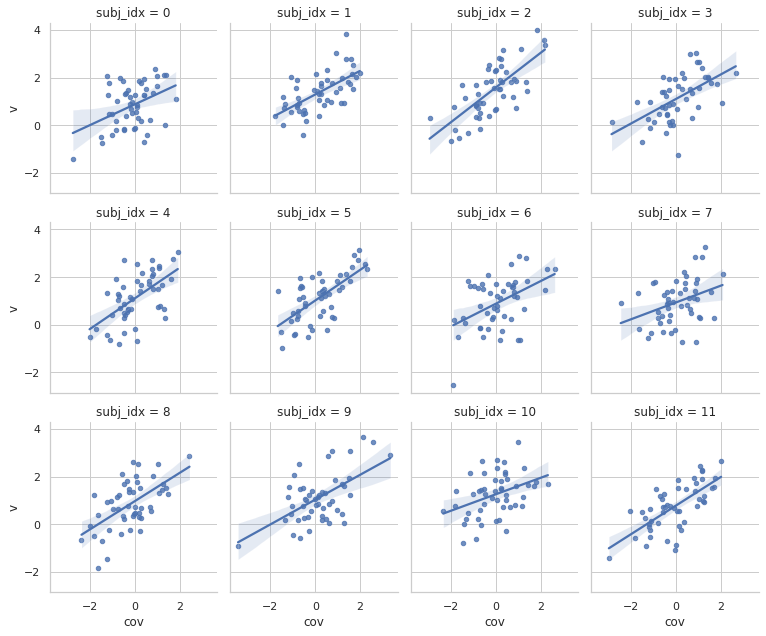

In [61]:
sns.lmplot(x='cov',
           y='v', 
           data=wfpt_v,  
           col = 'subj_idx',
           col_wrap=4,    
           fit_reg=True,   
           aspect=0.9,    
           scatter_kws={'s': 20}, 
           size=3) 

In [14]:
# contrust model
m1 = bmb.Model("v ~ 1+cov+(1|subj_idx)", data=wfpt_v)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=1,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [v_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, cov, Intercept]


Sampling 1 chain for 1_000 tune and 4_000 draw iterations (1_000 + 4_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'cov'}>], dtype=object)

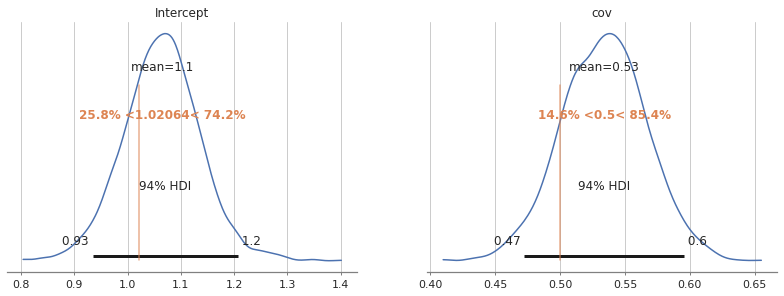

In [20]:
az.plot_posterior(res1, 
                  var_names=['Intercept','cov'], 
                  ref_val=[group_params['v_inter'].mean(),effect]
                 )

As we can see, the true value is in 95% HDI. so we can say the value estimated can be accepted.

## Visualisation Result

Then, we use raincloud pcture to show the group-level parameters and subject-level parameters as well as the generated data.

In [82]:
param = group_params

In [83]:
# select the specific coloumn
param = param[['v','a','t','z','subj_idx']]
# store the wide data to linear regression
param_pm = param
# wide to long
param = param.melt(id_vars='subj_idx', 
                   var_name='param', 
                   value_name='value' )

Text(0.5, 0, 't')

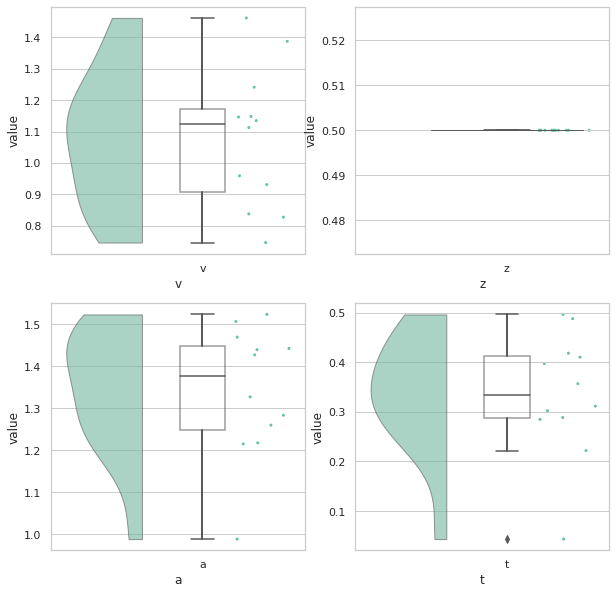

In [84]:
# create figure
f, ax = plt.subplots(2,2,figsize=(10, 10))
# the right figure
# v
ax[0,0]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='v'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,0])
ax[0,0].set_xlabel('v')
# z
ax[0,1]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='z'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,1])
ax[0,1].set_xlabel('z')
# a
ax[1,0]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='a'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,0])
ax[1,0].set_xlabel('a')
# t
ax[1,1]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='t'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,1])
ax[1,1].set_xlabel('t')


In [24]:
print('the mean of parameter v is {:.3f} and the std is {:.3f} '.format(param_pm.v.mean(), param_pm.v.std()))
print('the mean of parameter z is {:.3f} and the std is {:.3f} '.format(param_pm.z.mean(), param_pm.z.std()))
print('the mean of parameter a is {:.3f} and the std is {:.3f} '.format(param_pm.a.mean(), param_pm.a.std()))
print('the mean of parameter t is {:.3f} and the std is {:.3f} '.format(param_pm.t.mean(), param_pm.t.std()))

the mean of parameter v is 1.078 and the std is 0.224 
the mean of parameter z is 0.500 and the std is 0.000 
the mean of parameter a is 1.342 and the std is 0.157 
the mean of parameter t is 0.335 and the std is 0.124 


<AxesSubplot:xlabel='response', ylabel='rt'>

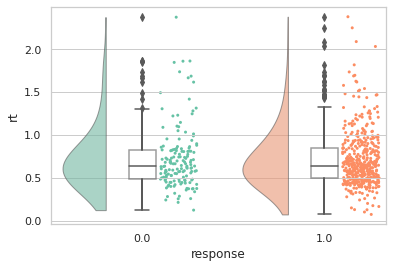

In [25]:
# the rt distribution
pt.RainCloud(x = 'response', 
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2)

# Constructing the model and fitting it


Because we only assignate the effcet into parameter v, so our model only have one parameter vary with the covariance.

In [27]:
m = hddm.HDDMRegressor(data, 
                       'v~cov', 
                       group_only_regressors=False,
                       keep_regressor_trace=True,
                      )
m.sample(4000,burn=1000)

Adding these covariates:
['v_Intercept', 'v_cov']
 [-----------------100%-----------------] 4000 of 4000 complete in 567.0 sec

## Inspect the trace

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_cov
Plotting v_cov_std


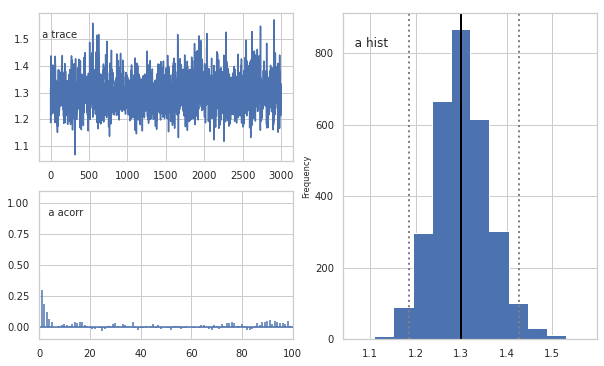

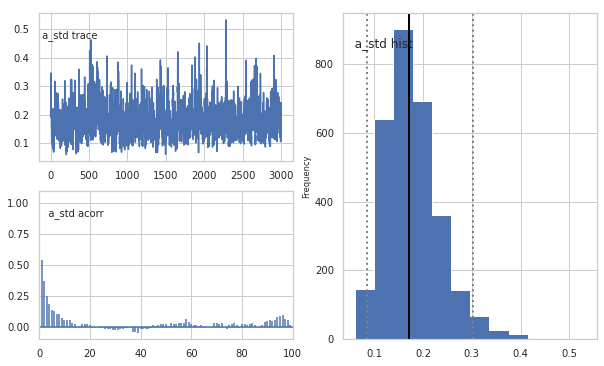

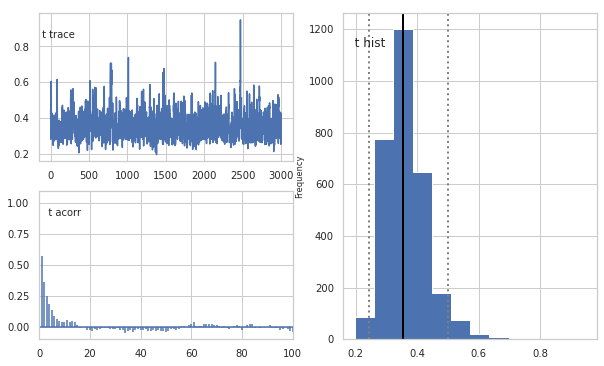

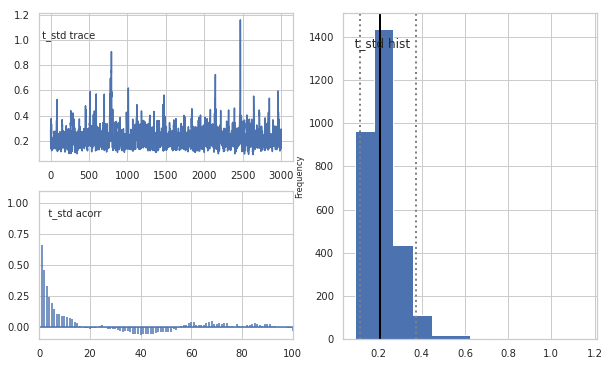

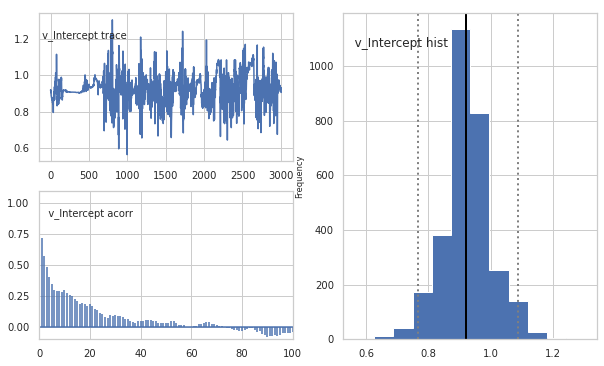

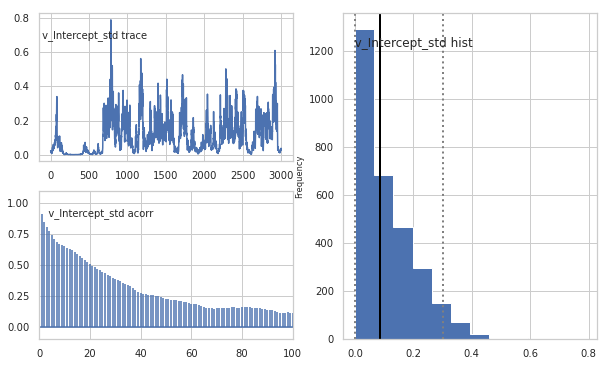

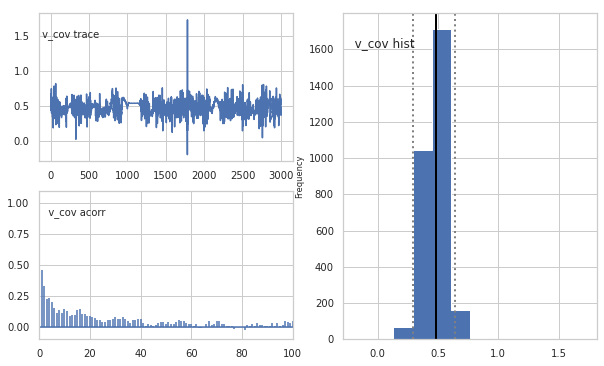

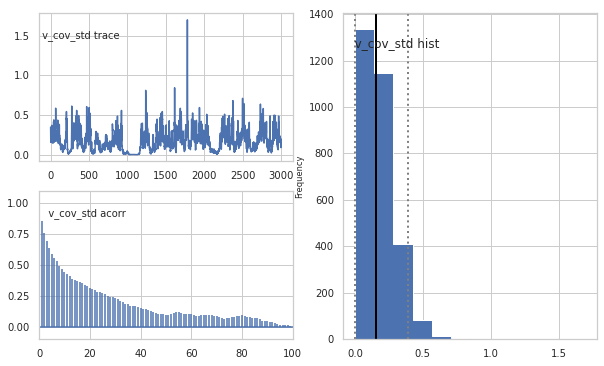

In [32]:
m.plot_posteriors()

Inspect the trace of each paramter, the sample of them is close to Convergence.

In [33]:
m.get_traces().to_csv('mres.csv')

In [34]:
m1res_trace = pd.read_csv('mres.csv')

## Inspect the results

After the sample of trace has convergened, we should check whether the value of parameter estimated by the model is similar to the value we set.

### group-level params

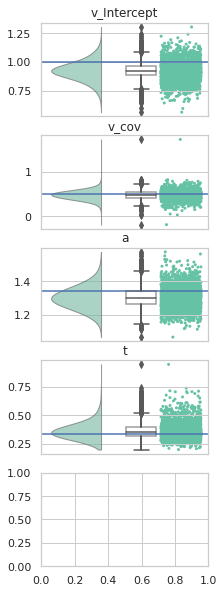

In [36]:
pms = ['v_Intercept','v_cov','a','t']
# create figure
f,ax = plt.subplots(5,figsize=(3,10))
for i,pm in enumerate(pms):
    if pm == 'a' or pm == 't':
        varname = os.path.join(str(pm))
        data = m1res_trace[varname]
        # ground parameter of group effect
        gpm = param_pm[pm].mean()
    elif pm == 'v_Intercept':
        varname = os.path.join(str(pm ))
        data = m1res_trace[varname]
        gpm= 1
    elif pm == 'v_cov':
        varname = os.path.join(str(pm ))
        data = m1res_trace[varname]
        gpm=0.5        
    elif pm == 'z':
        varname = os.path.join(str(pm +'_trans'))
        data = 1/(1+np.exp(-m1res_trace[varname]))
        gpm=param_pm[pm].mean()
    
    # raincloud
    ax_i = pt.RainCloud(data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax[i])
    ax_i.axhline(gpm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(pm)

We can see the mean of estimated parameters is close to the true parameter. The result of parameter recovery of group-level is acceptable.

### subject-level params

#### v

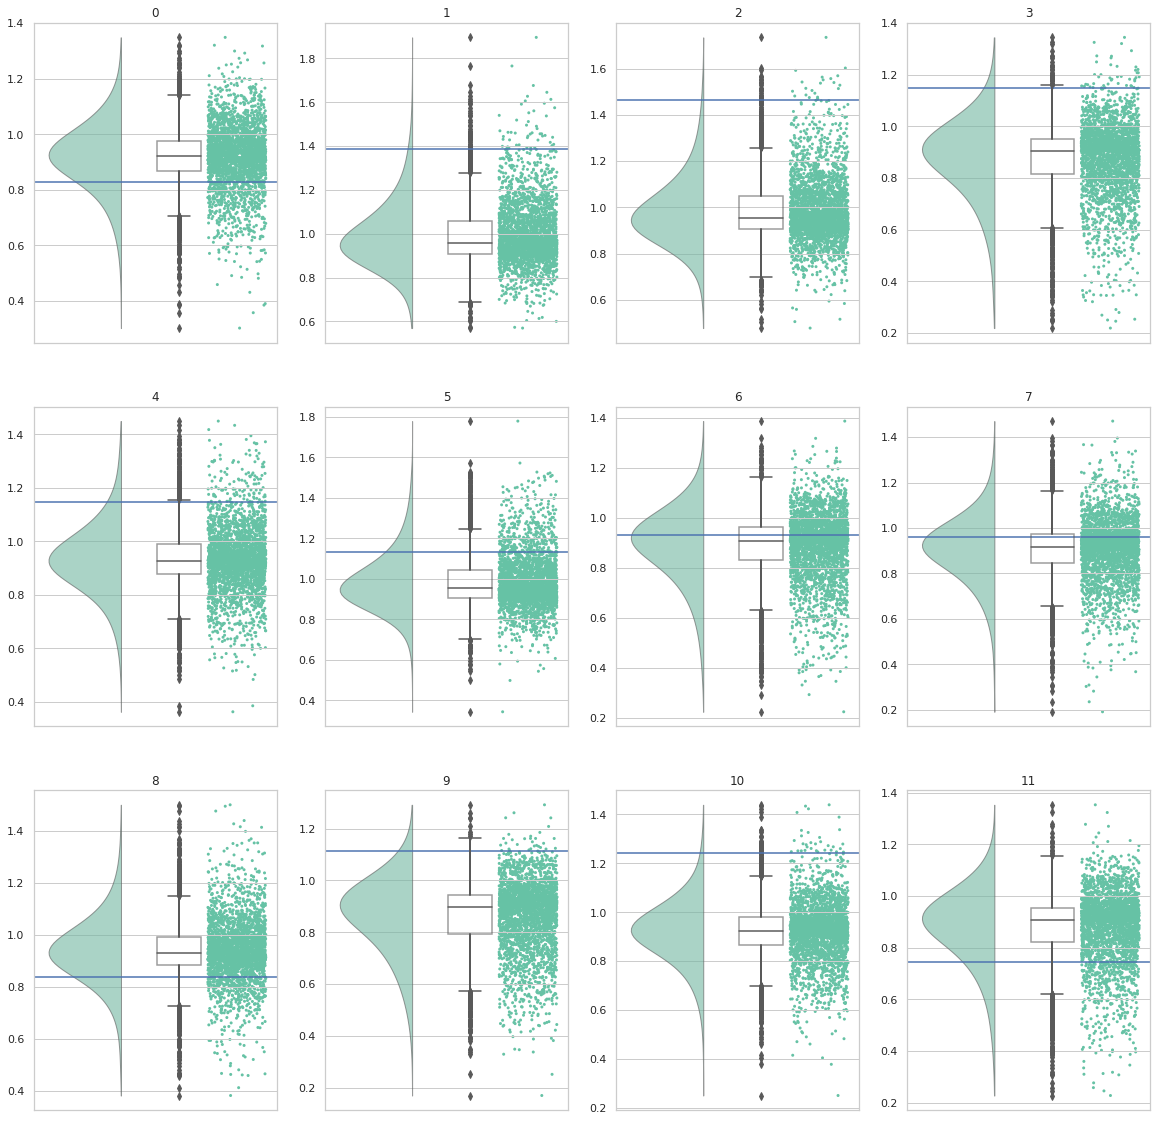

In [37]:
param = 'v'
# create figure
f,ax = plt.subplots(3,4,figsize=(20,20))
for i in range(n_subjs):
    varname = os.path.join(str(param +'_Intercept_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'v'].values[0]
    # raincloud
    ax_i = ax[i//4,i%4]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

#### z

KeyError: 'z_subj_trans.0'

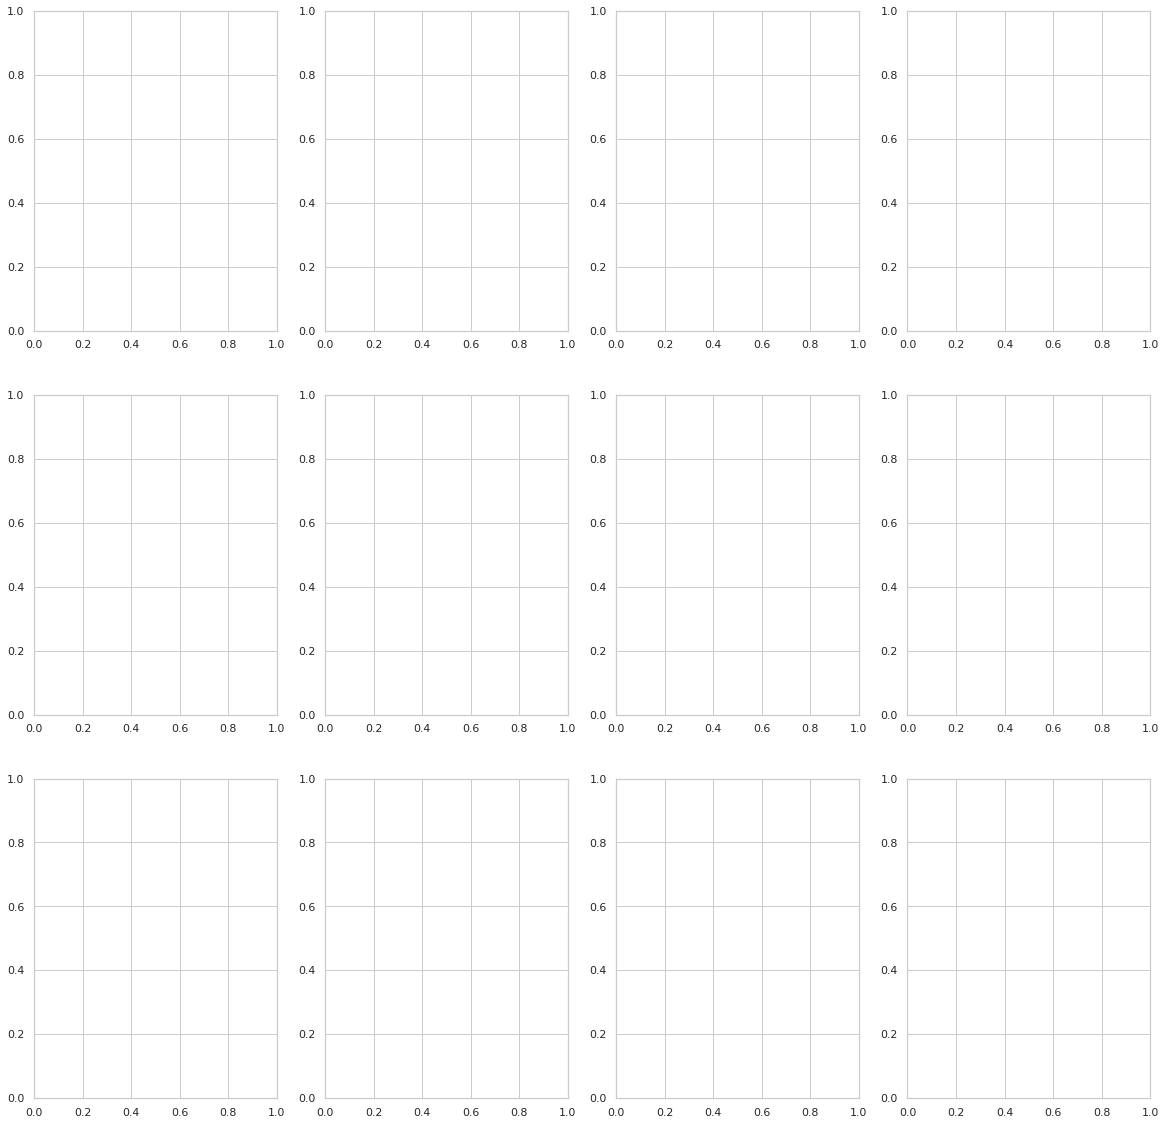

In [38]:
param = 'z'
# create figure
f,ax = plt.subplots(3,4,figsize=(20,20))
for i in range(n_subjs):
    varname = os.path.join(str(param +'_subj_trans.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'z'].values[0]
    # raincloud
    ax_i = ax[i//4,i%4]
    ax_i = pt.RainCloud(data = 1/(1+np.exp(-m1res_trace[varname])), 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

#### t

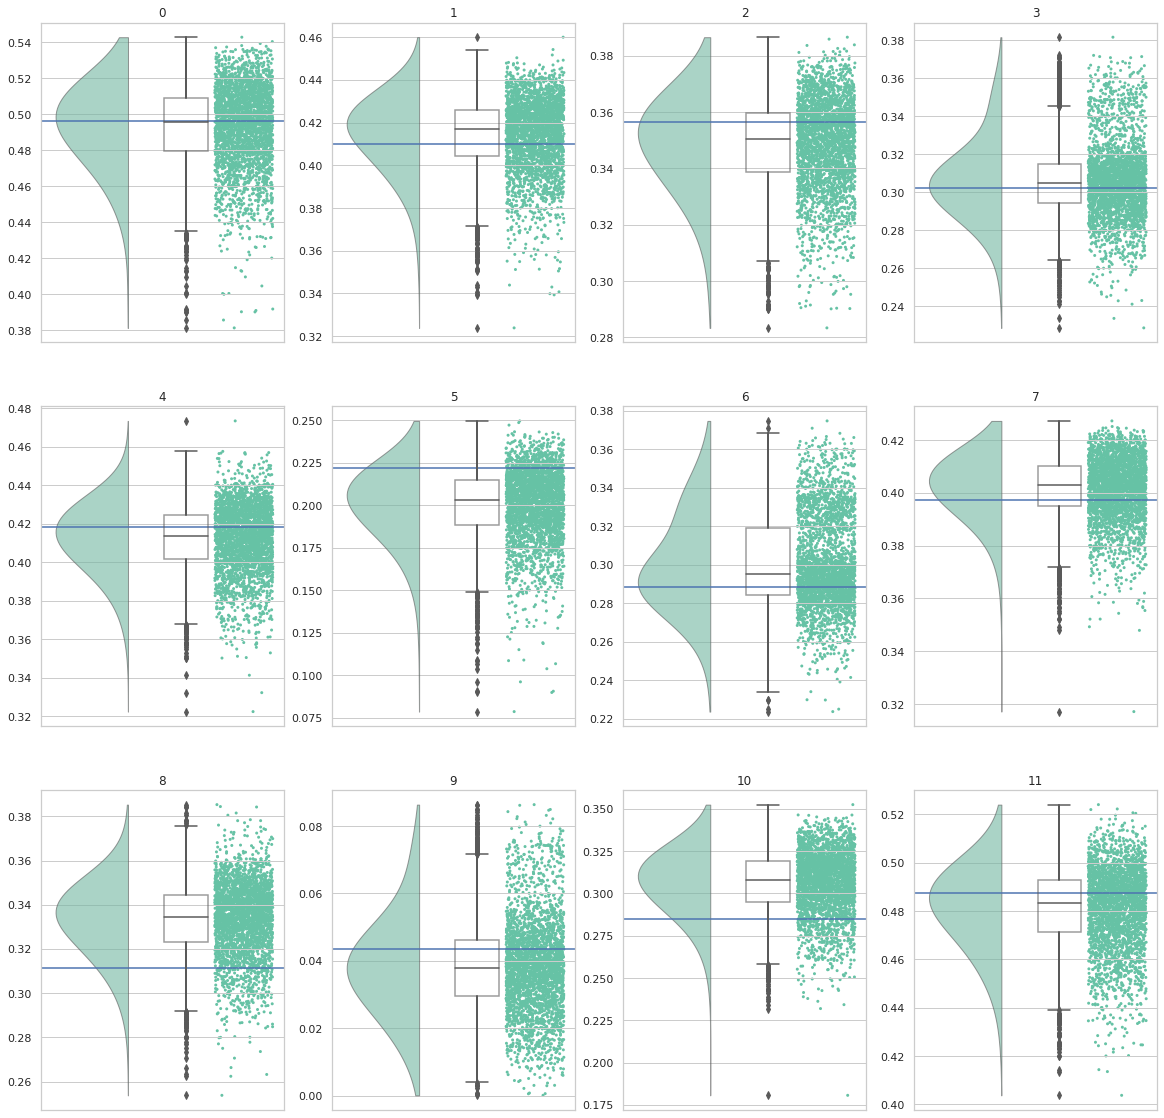

In [85]:
param = 't'
# create figure
f,ax = plt.subplots(3,4,figsize=(20,20))
for i in range(n_subjs):
    varname = os.path.join(str(param +'_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'t'].values[0]
    # raincloud
    ax_i = ax[i//4,i%4]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

#### a

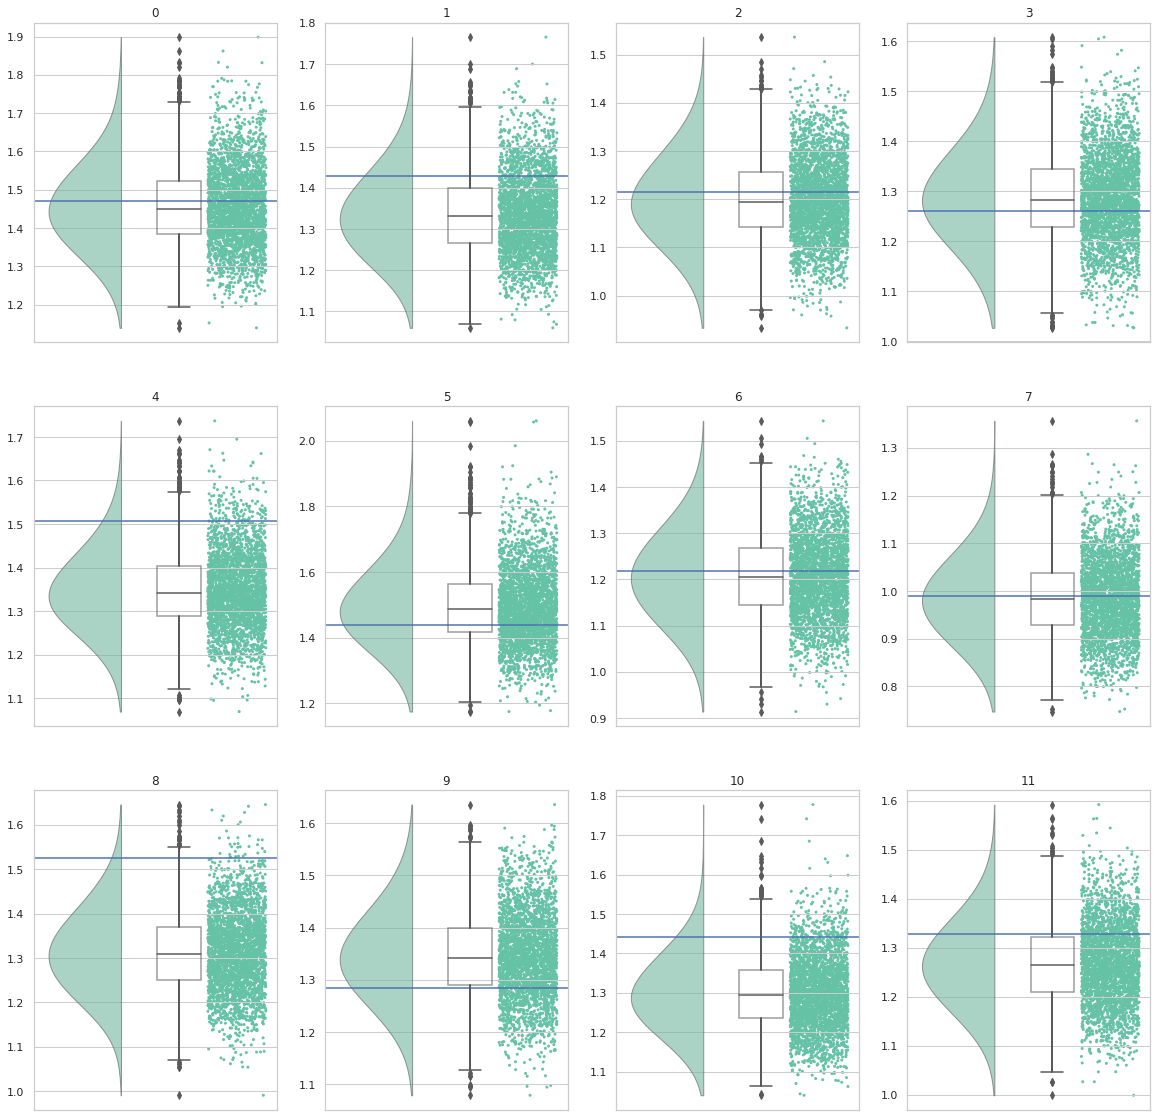

In [86]:
param = 'a'
# create figure
f,ax = plt.subplots(3,4,figsize=(20,20))
for i in range(n_subjs):
    varname = os.path.join(str(param +'_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'a'].values[0]
    # raincloud
    ax_i = ax[i//4,i%4]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

But the result of parameter recovery of subject-level is not so acceptable than group-level. 